In [22]:
import numpy as np
import matplotlib.pylab as plt
import stretchablecorr as sc

Available samples
0 - example_PDMS_18j
1 - .ipynb_checkpoints
2 - not_used
3 - HS2
4 - hpr1


> Select an image directory: 3


HS2 selected
Load images from ./images/HS2...
Image sequence:
 23 frames , 1392*1024 pixels , memory size: 250 Mo
 images: 00p000001.TIF, 00p100012.TIF, 00p200023.TIF , ... ,  55p000267.TIF


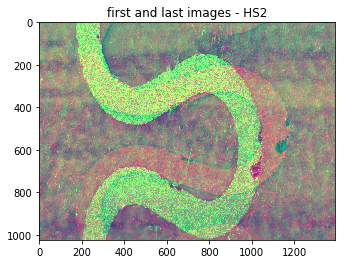

In [23]:
# ==================
#  Load image cube
# ==================
metadata = {}
sample_name, sample_input_dir = sc.select_sample_dir('./images')
cube, image_names = sc.load_image_sequence(sample_input_dir)
metadata['sample_name'] = sample_name

plt.figure(); plt.title(f'first and last images - {sample_name}');
sc.imshow_color_diff(cube[0], cube[-1]);

grid size: 80x55
 i.e. 4400 points


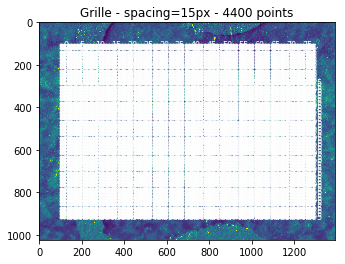

In [24]:
# ===============
#  Define a grid
# ===============
# margin > window_half_size
# margin > largest displacement

grid_spacing =  15  # px
grid_margin  = 100  # px

# ----
grid = sc.build_grid(cube.shape[1:], margin=grid_margin, spacing=grid_spacing)
points = np.stack( (grid[0].flatten(), grid[1].flatten()), axis=-1 )

metadata['grid_spacing'] = grid_spacing
metadata['grid_margin'] = grid_margin

# Graph
plt.figure();
plt.title(f'Grille - spacing={grid_spacing}px - {points.shape[0]} points');
sc.plot_grid_points(grid, background=cube[0],
                    color='white', markersize=3, show_pts_number=True,
                    window_half_size=None)

In [25]:
# =====================
#  Coarse displacement
# =====================

downscale = 3
params = {'window_half_size': 35,
          'method':'opti',
          'phase':True
         }

cube_reduced = [sc.pyramid_reduce(I, downscale=downscale) for I in cube]
points_reduced = points / downscale

print('actual window half size:', params['window_half_size']*downscale)
displ_coarse, err = sc.track_displ_img_to_img(cube_reduced, points_reduced, **params)
displ_coarse = displ_coarse * downscale

print('max displ:', np.nanmax(np.sqrt(np.sum(displ_coarse**2, axis=-1))), 'px')

# save metadata
meta_coarse = {'coarse_param':params, 'coarse_downscale':downscale}
metadata.update(meta_coarse)

actual window half size: 105
Compute image-to-image Lagrangian displacement field:
done                               
max displ: 57.01577582989962 px


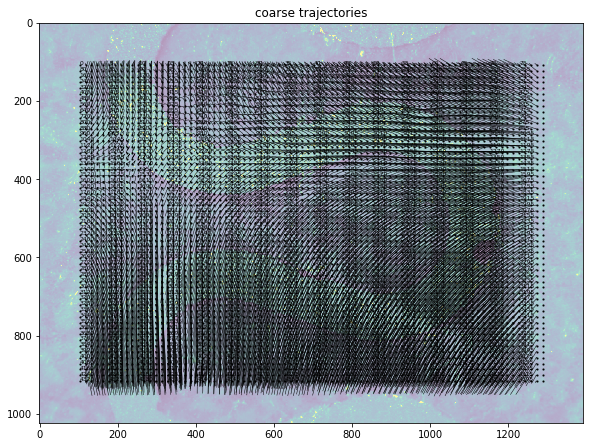

In [26]:
coarse_trajectories = sc.integrate_displacement(displ_coarse) + points

plt.figure(figsize=(10, 10*cube.shape[1]/cube.shape[2]));
sc.plot_trajectories(coarse_trajectories, background=cube[0])
plt.title('coarse trajectories');

In [27]:
# ============
#  Refinement 
# ============

params = {'window_half_size': 20,
          'method':'opti',
          'phase':False}

displ, err = sc.track_displ_img_to_img(cube, points,
                                       offsets=displ_coarse,
                                       **params)

print('max displ:', np.nanmax(np.sqrt(np.sum(displ**2, axis=-1))), 'px')

Compute image-to-image Lagrangian displacement field:
done                               
max displ: 72.16530780909962 px


In [28]:
# save metadata & data
metadata.update(params)
sc.save_data((grid, displ, err, metadata),
             f'displ_Lagrangian_{len(points)}pts',
             sample_name)

data saved at ./output/HS2/displ_Lagrangian_4400pts_160905.pck


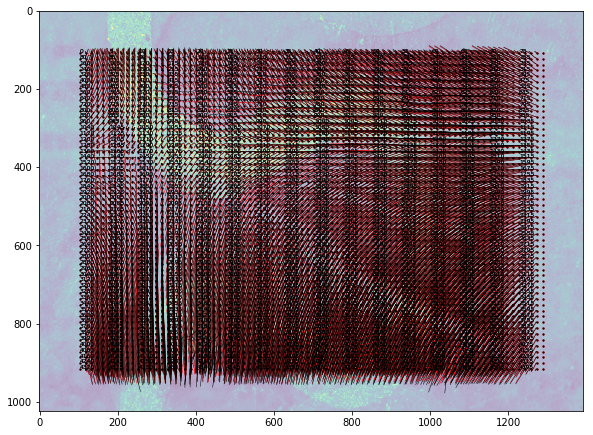

In [29]:
# Graph
trajectories = sc.integrate_displacement(displ) + points

plt.figure(figsize=(10, 10*cube.shape[1]/cube.shape[2]));
cube_last_first = (cube[0] + cube[-1])/2
sc.plot_trajectories(coarse_trajectories, background=cube_last_first, color='r')
sc.plot_trajectories(trajectories, background=None)

In [15]:
# =====================
#  Mutli peak method
# =====================

params = {'coarse_window_half_size': 80,
          'window_half_size': 20,
          'method':'multipeak'
         }

displ_multi, err = sc.track_displ_img_to_img(cube, points, **params)

print('max displ:', np.nanmax(np.sqrt(np.sum(displ_multi**2, axis=-1))), 'px')

Compute image-to-image Lagrangian displacement field:
done                               
max displ: 59.892592693718804 px


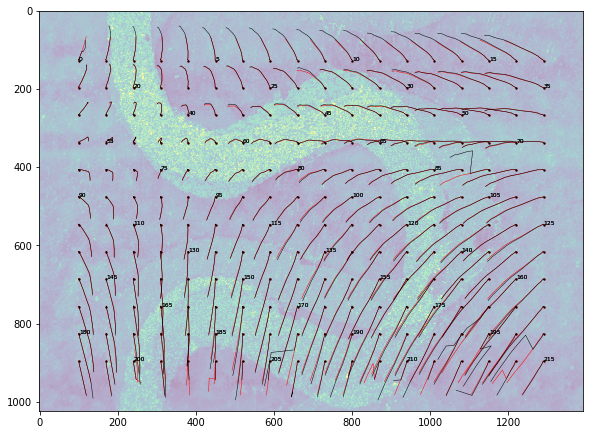

In [19]:
# Graph
trajectories_multi = sc.integrate_displacement(displ_multi) + points

plt.figure(figsize=(10, 10*cube.shape[1]/cube.shape[2]));
cube_last_first = (cube[0] + cube[-1])/2
sc.plot_trajectories(coarse_trajectories, background=cube_last_first, color='r')
sc.plot_trajectories(trajectories_multi, background=None)

In [10]:
# ====================
#  two steps tracking 
# ====================

params = {'window_half_size': 20,
          'method':'opti',
          'phase':False, 'coarse_search':True}
tw_steps_displ, gaps, err1, err2 = sc.track_displ_2steps(cube, points,
                                                         offsets=None,
                                                         **params)

Compute image-to-image Lagrangian displacement field:
len(offsets) 2 ---  point:   0 ...
len(offsets) 2 ---  point:   0 ...
len(offsets) 3 ---  point:   0 ...
len(offsets) 5 ---  point:   2 ...
len(offsets) 8 ---  point:   2 ...
len(offsets) 5 ---  point:   3 ...
len(offsets) 2 ---  point:   4 ...
len(offsets) 3 ---  point:   4 ...
len(offsets) 2 ---  point:   4 ...
len(offsets) 2 ---  point:   5 ...
len(offsets) 2 ---  point:   5 ...
len(offsets) 2 ---  point:   5 ...
len(offsets) 2 ---  point:   5 ...
len(offsets) 6 ---  point:  10 ...
len(offsets) 2 ---  point:  10 ...
len(offsets) 2 ---  point:  12 ...
len(offsets) 3 ---  point:  13 ...
len(offsets) 3 ---  point:  13 ...
len(offsets) 13 --- point:  18 ...
len(offsets) 2 ---  point:  19 ...
len(offsets) 12 --- point:  22 ...
len(offsets) 13 --- point:  26 ...
len(offsets) 11 --- point:  26 ...
len(offsets) 2 ---  point:  27 ...
len(offsets) 2 ---  point:  30 ...
len(offsets) 13 --- point:  30 ...
len(offsets) 2 ---  point:  33 ...
l

In [6]:
# graph
tw_steps_trajectories = sc.integrate_displacement(tw_steps_displ) + points

plt.figure(figsize=(10, 10*cube.shape[1]/cube.shape[2]));
sc.plot_trajectories(tw_steps_trajectories,
                     background=cube[0], gaps=gaps)

NameError: name 'tw_steps_displ' is not defined

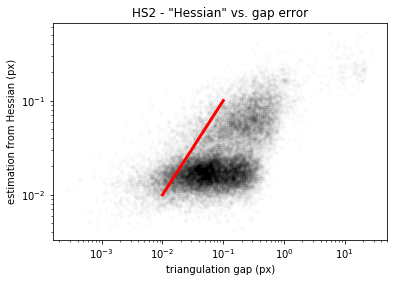

In [16]:
plt.title(f'{sample_name} - "Hessian" vs. gap error');
plt.loglog(gaps.flatten(), np.sqrt(err2[:, :, 1].flatten()), '.k', alpha=0.01);
identity_line = [1e-2, 1e-1]
plt.loglog(identity_line, identity_line, '-r', linewidth=3)
plt.xlabel('triangulation gap (px)');
plt.ylabel('estimation from Hessian (px)');

## Test coarse_search (v2)

In [4]:
params = {'window_half_size': 30,
          'method':'opti',
          'phase':False,
          'coarse_search':True}

displ, err = sc.track_displ_img_to_img(cube, points,
                                       offsets=None,
                                       **params)

print('max displ:', np.nanmax(np.sqrt(np.sum(displ**2, axis=-1))), 'px')

Compute image-to-image Lagrangian displacement field:
done                               
max displ: 48.5175896821541 px


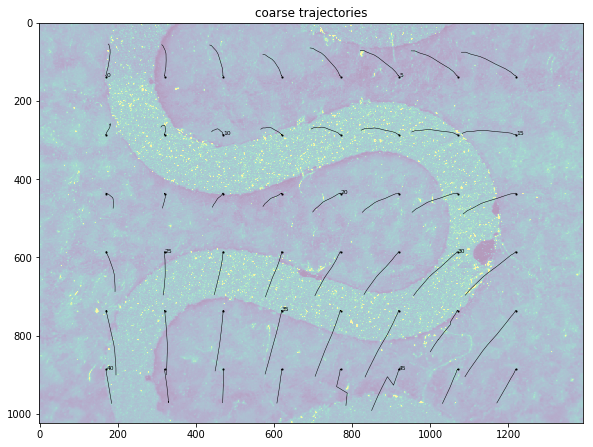

In [5]:
trajectories = sc.integrate_displacement(displ) + points

plt.figure(figsize=(10, 10*cube.shape[1]/cube.shape[2]));
sc.plot_trajectories(trajectories, background=cube[0])
plt.title('coarse trajectories');